In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.cycle_gan import CycleGanDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "cycle_gan"
data_set_name = "HE_IHC_dataset"
batch_size = 8
on_memory = False
argumentation_proba = 0.8
target_size = (256,256)
interpolation = "bilinear"
class_mode = "binary"
# class_mode = "categorical"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/train/*/*")
train_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/train/*/*")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/HE/test/*/*")
test_target_image_path_list = glob(f"./datasets/{task}/{data_set_name}/IHC/test/*/*")

train_data_loader = CycleGanDataloader(image_path_list=train_image_path_list,
                                       target_image_path_list=train_target_image_path_list,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       dtype=dtype
)
test_data_loader = CycleGanDataloader(image_path_list=test_image_path_list,
                                      target_image_path_list=test_target_image_path_list,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       dtype=dtype
)

Source data num 11000, Target data num: 11000
Source data num 3000, Target data num: 3000


In [3]:
from copy import deepcopy

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import sigmoid
from tensorflow.image import ssim
import segmentation_models as sm
from tensorflow.keras.applications import InceptionV3

from src.model.build_model import build_generator, build_discriminator
from src.util.custom_loss import dice_score
from src.util.loss_cycle_gan import get_channel_weighted_dice_loss
from src.model.cycle_gan import CycleGan

BACKBONE="inceptionv3"
optimizer = Nadam(1e-5, beta_1=0.5, clipnorm=1)
input_image_shape = (*target_size, 3)
output_image_shape = (*target_size, 3)

generator_G = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")
generator_F = sm.Unet(backbone_name=BACKBONE, 
                      input_shape=(None, None, 3), 
                      classes=3, activation="tanh")

base_discriminator_X = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)
discriminator_X_sigmoid = sigmoid(base_discriminator_X.output)
discriminator_X = Model(base_discriminator_X.input, discriminator_X_sigmoid)

base_discriminator_Y = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)
discriminator_Y_sigmoid = sigmoid(base_discriminator_Y.output)
discriminator_Y = Model(base_discriminator_Y.input, discriminator_Y_sigmoid)

cycle_gan_model = CycleGan(
    generator_G=generator_G, 
    generator_F=generator_F, 
    discriminator_X=discriminator_X, 
    discriminator_Y=discriminator_Y
)

cycle_gan_model.compile(
    generator_G_optimizer=optimizer,
    generator_F_optimizer=optimizer,
    discriminator_X_optimizer=optimizer,
    discriminator_Y_optimizer=optimizer,
    image_loss=get_channel_weighted_dice_loss
)


Segmentation Models: using `keras` framework.


In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            image_array, target_image_array = self.data_loader[image_index]
            prediction = self.model.generator_G(image_array).numpy()[0]
            reverse_prediction = self.model.generator_F(target_image_array).numpy()[0]
            
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            reverse_prediction = (reverse_prediction * 127.5 + 127.5).astype(np.uint8)
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image")
            ax[current_index, 1].set_title("Translated image")
            ax[current_index, 0].axis("off")
            ax[current_index, 1].axis("off")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
            prediction.save(
                f"generated_image_{current_index}_{epoch}.png"
            )
            reverse_prediction.save(
                f"generated_reverse_image_{current_index}_{epoch}.png"
            )
        plt.show()
        plt.close()
        
class ModelCheckpointWithWeight(ModelCheckpoint):
    """A callback to generate and save images after each epoch"""

    def __init__(self, *args, **kwargs):
        super(ModelCheckpointWithWeight, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super(ModelCheckpointWithWeight, self).on_epoch_end(epoch, logs=logs)
        save_folder = self.filepath.format(epoch=epoch+1)
        
        self.model.generator_G.save_weights(f"{save_folder}/generator_G.hdf5")
        self.model.generator_F.save_weights(f"{save_folder}/generator_F.hdf5")
        self.model.discriminator_X.save_weights(f"{save_folder}/discriminator_X.hdf5")
        self.model.discriminator_Y.save_weights(f"{save_folder}/discriminator_Y.hdf5")


In [5]:
plotter = GANMonitor(data_loader=test_data_loader, num_img=4)
checkpoint_filepath = "./cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = ModelCheckpointWithWeight(
    filepath=checkpoint_filepath
)

Epoch 1/20
1375/1375 [==============================] - 1592s 1s/step - G_loss: 18.0384 - F_loss: 20.1264 - D_X_loss: 0.4633 - D_Y_loss: 0.4619


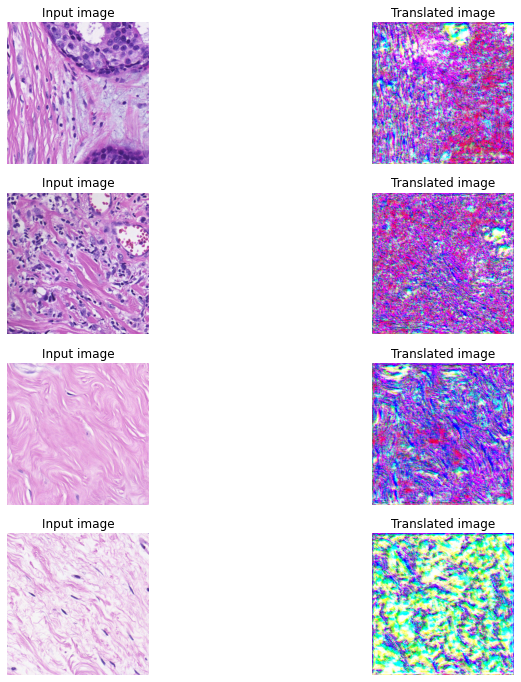

INFO:tensorflow:Assets written to: .\cyclegan_checkpoints.001\assets
Epoch 2/20
1375/1375 [==============================] - 1479s 1s/step - G_loss: 18.0434 - F_loss: 20.1470 - D_X_loss: 0.4499 - D_Y_loss: 0.4498


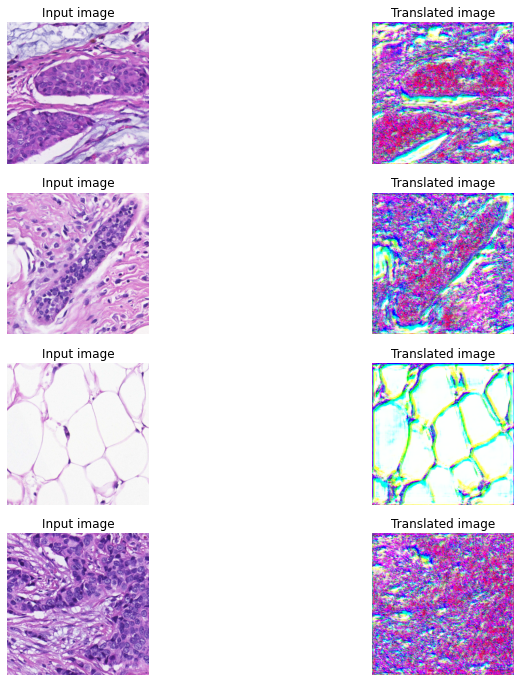

INFO:tensorflow:Assets written to: .\cyclegan_checkpoints.002\assets
Epoch 3/20
 965/1375 [====================>.........] - ETA: 7:23 - G_loss: 17.9987 - F_loss: 20.1374 - D_X_loss: 0.4489 - D_Y_loss: 0.4487

KeyboardInterrupt: 

In [6]:
cycle_gan_model.fit(
    train_data_loader,
    epochs=20,
    callbacks=[plotter, model_checkpoint_callback],
)

# Unused Code

In [7]:
image_array, target_image_array = train_data_loader[0]

In [8]:
converted = generator_G(image_array)[0]
converted = np.array(converted)
converted = (converted + 1) * 127.5
converted = converted.astype("uint8")

In [9]:
temp_array = image_array[0]
temp_array = (temp_array + 1) * 127.5
temp_array = temp_array.astype("uint8")

In [36]:
from tensorflow.keras import backend as K

beta=0.7
CHANNEL_WEIGHTED_AXIS=[1,2]
smooth=K.epsilon()

alpha = 1 - beta

y_true = tf.constant(image_array)
y_pred = tf.constant(image_array)

y_true = (y_true + 1 + smooth) / 2
y_pred = (y_pred + 1 + smooth) / 2

prevalence_per_channel = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

weight_per_channel = 1 / prevalence_per_channel
weight_per_channel_sum = K.sum(weight_per_channel, axis=-1)
weight_per_channel_sum = tf.expand_dims(weight_per_channel_sum, axis=-1)
weight_per_channel = weight_per_channel / weight_per_channel_sum

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + weight_per_channel)

print(channel_weighted_dice_loss)

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

tf.Tensor(
[[0.28803957 0.30367628 0.287329  ]
 [0.2565217  0.2646555  0.25332776]
 [0.27474865 0.28615132 0.2729129 ]
 [0.25315574 0.26411    0.2497732 ]
 [0.25310755 0.261549   0.24944559]
 [0.22046675 0.2446485  0.21239144]
 [0.29353285 0.30533555 0.29198378]
 [0.26282158 0.27531525 0.25400543]], shape=(8, 3), dtype=float32)


In [33]:
y_true = (y_true + 1 + smooth) / 2
y_pred = (y_pred + 1 + smooth) / 2

prevalence_per_channel = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

weight_per_channel = 1 / prevalence_per_channel
weight_per_channel_sum = K.sum(weight_per_channel, axis=-1)
weight_per_channel_sum = tf.expand_dims(weight_per_channel_sum, axis=-1)
weight_per_channel = weight_per_channel / weight_per_channel_sum

mse_loss = (y_true - y_pred) ** 2
mse_loss = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

channel_weighted_dice_loss = K.mean(mse_loss)


In [34]:
mse_loss

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[0.9762006 , 0.943473  , 0.97611606],
       [0.9653507 , 0.89872915, 0.9724424 ],
       [0.96594495, 0.9281926 , 0.9710499 ],
       [0.9556898 , 0.9040121 , 0.9601167 ],
       [0.95882237, 0.89782107, 0.9692588 ],
       [0.92080796, 0.87275875, 0.94493645],
       [0.97390866, 0.9541371 , 0.9756861 ],
       [0.9442797 , 0.91519123, 0.9605514 ]], dtype=float32)>

In [28]:
channel_weighted_dice_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.892123>

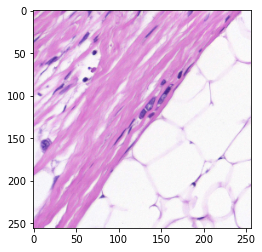

In [20]:
plt.imshow(temp_array)

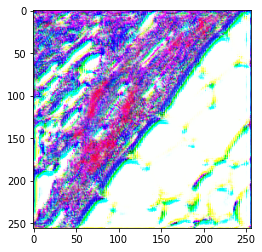

In [11]:
plt.imshow(converted)

In [ ]:
def train_step(batch_data):
    # x is Horse and y is zebra
    real_x, real_y = batch_data

    # For CycleGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
        # Horse to fake zebra
        fake_y = self.gen_G(real_x, training=True)
        # Zebra to fake horse -> y2x
        fake_x = self.gen_F(real_y, training=True)

        # Cycle (Horse to fake zebra to fake horse): x -> y -> x
        cycled_x = self.gen_F(fake_y, training=True)
        # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
        cycled_y = self.gen_G(fake_x, training=True)

        # Identity mapping
        same_x = self.gen_F(real_x, training=True)
        same_y = self.gen_G(real_y, training=True)

        # Discriminator output
        disc_real_x = self.disc_X(real_x, training=True)
        disc_fake_x = self.disc_X(fake_x, training=True)

        disc_real_y = self.disc_Y(real_y, training=True)
        disc_fake_y = self.disc_Y(fake_y, training=True)

        # Generator adverserial loss
        gen_G_loss = self.generator_loss_fn(disc_fake_y)
        gen_F_loss = self.generator_loss_fn(disc_fake_x)

        # Generator cycle loss
        cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
        cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

        # Generator identity loss
        id_loss_G = (
            self.identity_loss_fn(real_y, same_y)
            * self.lambda_cycle
            * self.lambda_identity
        )
        id_loss_F = (
            self.identity_loss_fn(real_x, same_x)
            * self.lambda_cycle
            * self.lambda_identity
        )

        # Total generator loss
        total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
        total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

        # Discriminator loss
        disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
        disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

    # Get the gradients for the generators
    grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
    grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

    # Get the gradients for the discriminators
    disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

    # Update the weights of the generators
    self.gen_G_optimizer.apply_gradients(
        zip(grads_G, self.gen_G.trainable_variables)
    )
    self.gen_F_optimizer.apply_gradients(
        zip(grads_F, self.gen_F.trainable_variables)
    )

    # Update the weights of the discriminators
    self.disc_X_optimizer.apply_gradients(
        zip(disc_X_grads, self.disc_X.trainable_variables)
    )
    self.disc_Y_optimizer.apply_gradients(
        zip(disc_Y_grads, self.disc_Y.trainable_variables)
    )

    return {
        "G_loss": total_loss_G,
        "F_loss": total_loss_F,
        "D_X_loss": disc_X_loss,
        "D_Y_loss": disc_Y_loss,
    }

# Unused Code

In [ ]:
y_true = train_data_loader[0][0]
y_true = tf.convert_to_tensor(y_true)
one_array = np.ones((1,512,512,3))
one_diff_array = deepcopy(one_array)
one_diff_array[:,:,:,0] = 0
one_diff_array[:,:30,:30,1] = 0

one_array = tf.convert_to_tensor(one_array)
one_diff_array = tf.convert_to_tensor(one_diff_array)

In [ ]:
beta = 0.7
CHANNEL_WEIGHTED_AXIS = [1, 2]
y_true = one_array
y_pred = one_diff_array
smooth = K.epsilon()

alpha = 1 - beta
prevalence_per_channel = \
    K.mean((y_true + 1) / 2, axis=CHANNEL_WEIGHTED_AXIS)

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = \
    (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + prevalence_per_channel)

print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
print(f"channel_weighted_dice_loss: {channel_weighted_dice_loss.shape}")

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

print(f"prevalence_per_channel_shape: {prevalence_per_channel.shape}")
print(f"true_positive_shape: {tp.shape}")
print(f"false_positive_shape: {tp.shape}")
print(f"false_negative_shape: {tn.shape}")
print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
